In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
import scipy.signal as sp
import numpy.linalg as nplin
from gekko import GEKKO

from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.signal import place_poles
from scipy.signal import find_peaks
from scipy.linalg import solve_continuous_are


from plotfunc import plot_sets

In [2]:
R=0.5
L=0.2
C=0.5

A=np.array([[0,1],[-1/(L*C),-R/L]])
B=np.array([[0],[1/L]])

Q=np.array([[1,0],
            [0,1]])

R=np.array([[1]])

P = solve_continuous_are(A, B, Q, R)

print(f"Macierz P:")
print(P)

Macierz P:
[[1.59270823 0.0472136 ]
 [0.0472136  0.13189887]]


In [3]:
R_inv = np.linalg.inv(R) # Odwrotność macierzy R
K = R_inv @ B.T @ P

print("\nMacierz Wzmocnień K:")
print(K)


Macierz Wzmocnień K:
[[0.23606798 0.65949437]]


In [4]:
def model(x,t):
    R=0.5
    L=0.2
    C=0.5
    u=np.array([[1]])

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])

    dx=A@x+(B*u).flatten()
    return dx

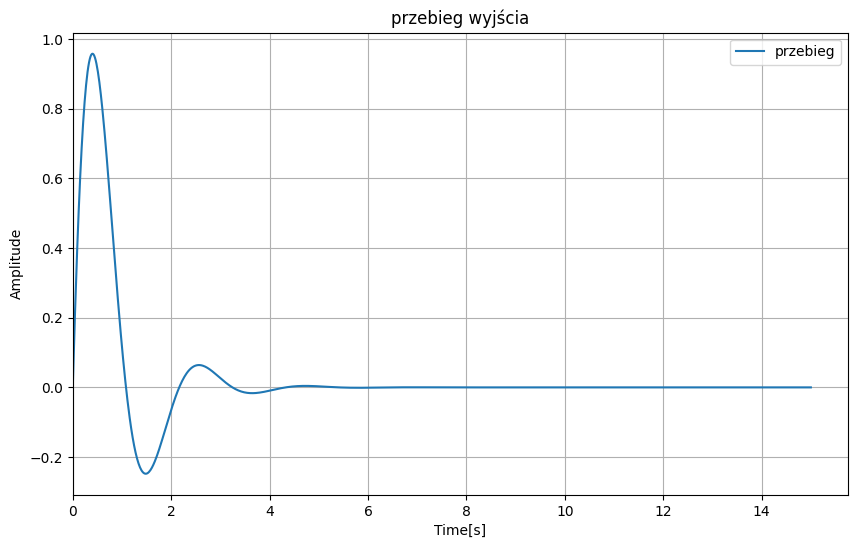

In [5]:
x0 = np.array([0, 0])

t = np.linspace(0, 15, 1000)

x = odeint(model, x0, t)

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [6]:
def model_with_K(x,t,K):
    R=0.5
    L=0.2
    C=0.5
    u=-K@x

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])
    
    dx=A@x+(B*u).flatten()
    return dx

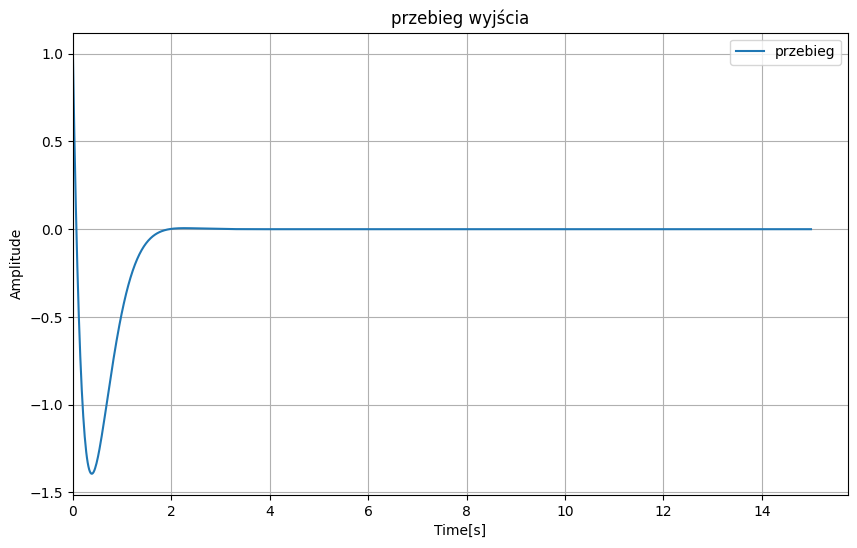

In [7]:
x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x = odeint(model_with_K, x0, t,args=(K,))

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [8]:
R1=np.array([[1]]) #"koszt" energetyczny 
Q1=np.array([[10,0], #"koszt" stanu 
             [0,10]])

P1 = solve_continuous_are(A, B, Q1, R1)
R1_inv = np.linalg.inv(R1) 
K1 = R1_inv @ B.T @ P1

R2=np.array([[10]])
Q2=np.array([[1,0],
             [0,1]])

P2 = solve_continuous_are(A, B, Q2, R2)
R2_inv = np.linalg.inv(R2) 
K2 = R2_inv @ B.T @ P2

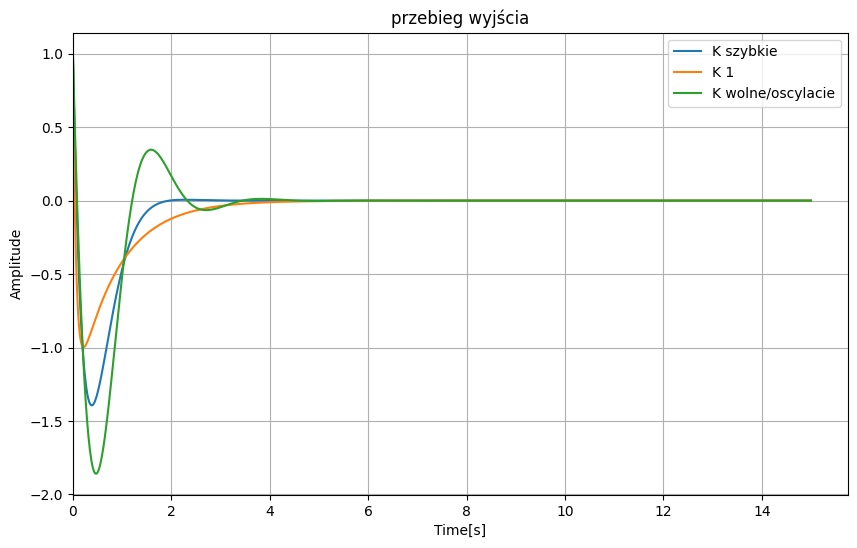

In [9]:

x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x1 = odeint(model_with_K, x0, t,args=(K,))
x2=odeint(model_with_K, x0, t,args=(K1,))
x3=odeint(model_with_K, x0, t,args=(K2,))


y1 = x1[:, 1]
y2 = x2[:, 1]
y3 = x3[:, 1]

plot_sets('przebieg wyjścia',[t,y1,'K szybkie'],
          [t,y2,'K 1'],
          [t,y3,'K wolne/oscylacie'])

In [10]:
A = np.array([[0.0, 1.0], [-10.0, -2.5]])
B = np.array([[0.0], [5.0]])

def model_cost_function(x_roz, t, K, Q, R_wag):
    # Krok 1: Wydobycie stanu nominalnego (x)
    x = x_roz[:2] 
    x_vec = x.reshape(2, 1) # Kolumnowy wektor stanu (2x1)

    # Krok 2: Sygnał sterujący (u)
    # u = -Kx (skalar)
    u = -K @ x 
    u_mat = np.array([[u]]) # Macierz 1x1 dla u

    # Krok 3: Obliczenie pochodnych stanu nominalnego (x_dot)
    # x_dot = A@x + B@u
    x_dot_nominal_matrix = A @ x_vec + B @ u_mat
    
    # Krok 4: Obliczenie wyrażenia podcałkowego J_dot
    # J_dot = x^T * Q * x + u^T * R_wag * u
    cost_integrand = x_vec.T @ Q @ x_vec + u_mat.T @ R_wag @ u_mat
    
    
    # x_dot_nominal musi być spłaszczony do wektora 1D, aby konkatenacja była poprawna
    x_dot_nominal = x_dot_nominal_matrix.flatten() 
    cost_flat = cost_integrand.flatten()
    
    return np.concatenate((x_dot_nominal, cost_flat))

In [11]:
x0 = np.array([1, 1, 0])

t = np.linspace(0, 15, 1000)

R_w=np.array([[1]])

sol_LQR = odeint(model_cost_function, x0, t, args=(K, Q, R_w))
J_LQR = sol_LQR[-1, 2] # Wartość J_akum w ostatniej chwili

# Symulacja dla innych wzmocnień (nieoptymalne)
sol_Inne = odeint(model_cost_function, x0, t, args=(K1, Q1, R1))
J_Inne = sol_Inne[-1, 2]

sol_Inne2 = odeint(model_cost_function, x0, t, args=(K1, Q2, R2))
J_Inne2 = sol_Inne2[-1, 2]

print(f"Wartość wskaźnika J dla wzmocnień LQR: {J_LQR:.4f}")
print(f"Wartość wskaźnika J dla innych wzmocnień: {J_Inne:.4f}")
print(f"Wartość wskaźnika J dla innych wzmocnień: {J_Inne2:.4f}")

Wartość wskaźnika J dla wzmocnień LQR: 1.8190
Wartość wskaźnika J dla innych wzmocnień: 12.6379
Wartość wskaźnika J dla innych wzmocnień: 15.1932


# 3 skonczony horyzont czasowy 


In [12]:
A = np.array([[0.0, 1.0], [-10.0, -2.5]])
B = np.array([[0.0], [5.0]])

Q = np.eye(2)
R = np.array([[1.0]]) 
R_inv = np.linalg.inv(R)

def riccati(p,t):
    P=p.reshape((2, 2))

    P_dot = (P@A-P@B@R_inv@B.T@P+A.T@P+Q)*-1

    p_dot = P_dot.flatten()

    return p_dot

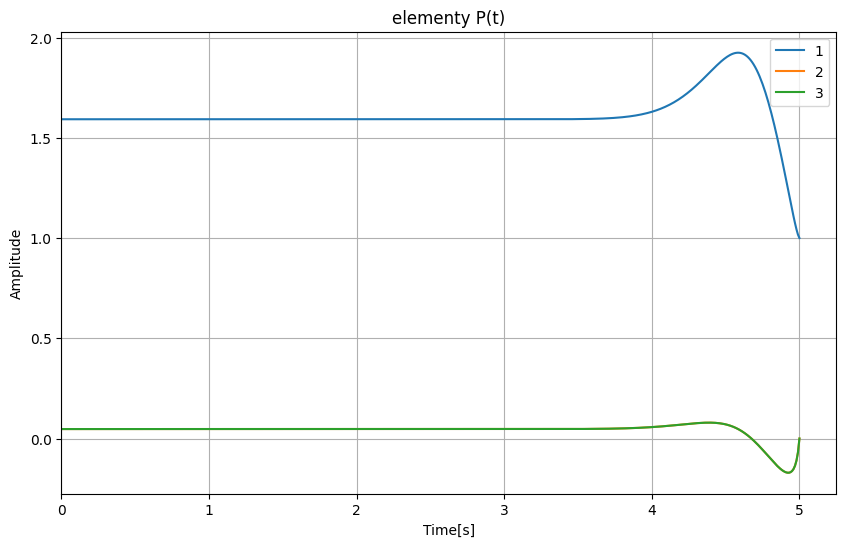

In [13]:
S = np.eye(2)
p0 = S.flatten()

t_r = np.arange(5,0,-0.01)

sol_riccati = odeint(riccati, p0, t_r)

P_t = sol_riccati

P_t_reversed = P_t[::-1] 
t_reversed = t_r[::-1]

plot_sets("elementy P(t)",[t_reversed,P_t_reversed[:,0],"1"],[t_reversed,P_t_reversed[:,1],"2"],[t_reversed,P_t_reversed[:,2],"3"])


In [14]:
A = np.array([[0.0, 1.0], [-10.0, -2.5]])
B = np.array([[0.0], [5.0]])

P_interp_P11 = interp1d(t_reversed, P_t_reversed[:, 0], kind='linear', fill_value='extrapolate')
P_interp_P12 = interp1d(t_reversed, P_t_reversed[:, 1], kind='linear', fill_value='extrapolate')
P_interp_P22 = interp1d(t_reversed, P_t_reversed[:, 3], kind='linear', fill_value='extrapolate')

def get_P_t(t):
    P11 = P_interp_P11(t)
    P12 = P_interp_P12(t)
    P22 = P_interp_P22(t)
    # Macierz P musi być symetryczna
    return np.array([[P11.item(), P12.item()], [P12.item(), P22.item()]])


def model_FTH(x_roz, t):
    # Krok 1: Wydobycie stanu nominalnego (x)
    x = x_roz[:2] 
    x_vec = x.reshape(2, 1) # Kolumnowy wektor stanu (2x1)

    P_t = get_P_t(t)

    K_t= K_t = R_inv @ B.T @ P_t
    
    u = -K @ x 
    u_mat = np.array([[u]]) 

    x_dot_nominal_matrix = A @ x_vec + B @ u_mat
    
    x_dot_nominal = x_dot_nominal_matrix.flatten() 
    
    return x_dot_nominal

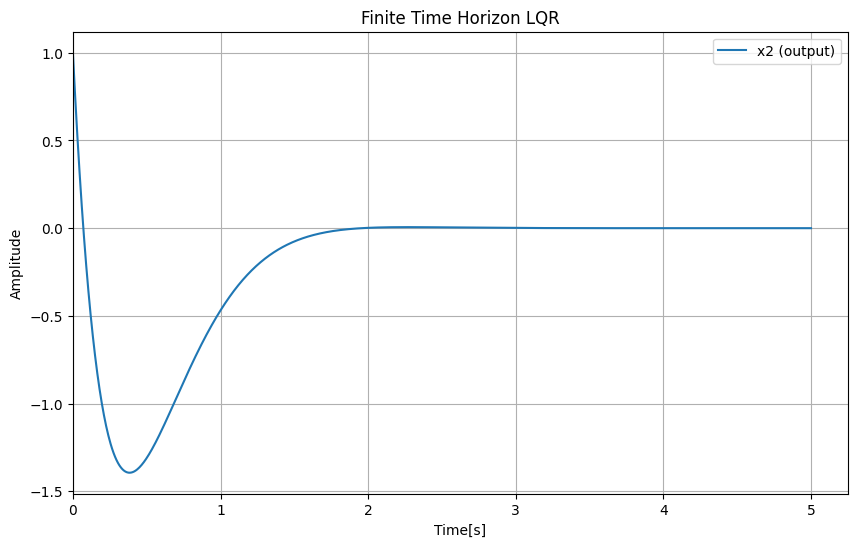

In [15]:
x0 = np.array([1, 1])

t = np.linspace(0, 5, 1000)

x_fth = odeint(model_FTH, x0, t)

y_fth = x_fth[:, 1]
plot_sets('Finite Time Horizon LQR', [t, y_fth, 'x2 (output)'])

## Zadanie 4.2 - Sterowanie do punktu pracy (Finite Horizon)
Układ z regulatorem LQR w skończonym horyzoncie czasu dla niezerowej wartości zadanej $q_d$.

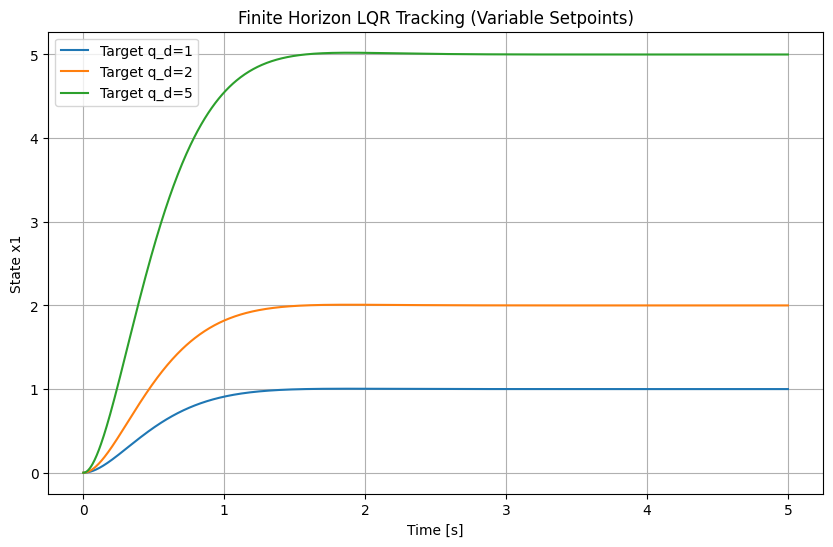

In [16]:
# Constants from previous cells
R_val = 0.5
L = 0.2
C = 0.5

# System matrices A, B are defined globally in notebook
# P_t interpolation functions are defined globally from previous steps

def model_FTH_setpoint(x_roz, t, x_d, u_d):
    # x_roz comes in as 1D array
    x = x_roz[:2]
    x_vec = x.reshape(2, 1)
    x_d_vec = x_d.reshape(2, 1)
    
    P_t = get_P_t(t)
    K_t = R_inv @ B.T @ P_t
    
    # Control Law: u = -K(x - x_d) + u_d
    u = -K_t @ (x_vec - x_d_vec) + u_d
    
    u_mat = u # scalar in (1,1) array
    
    # System dynamics: dx = Ax + Bu
    dx = A @ x_vec + B @ u_mat
    
    return dx.flatten()

# Simulation Loop
q_targets = [1, 2, 5]
t_sim = np.linspace(0, 5, 1000)
x0 = np.array([0, 0]) # Start from zero

plt.figure(figsize=(10, 6))
plt.title(f"Finite Horizon LQR Tracking (Variable Setpoints)")

for q_d in q_targets:
    # Calculate steady state targets
    # x1 = q, x2 = q_dot. Steady state: x2=0, x1=q_d
    x_d = np.array([q_d, 0])
    
    # Equilibrium: Ax_d + Bu_d = 0
    # Row 2: -1/(LC)*x1 - R/L*x2 + 1/L*u = 0
    # -1/(0.1)*q_d + 5*u_d = 0  => -10*q_d + 5*u_d = 0 => u_d = 2*q_d
    # Or generically: u_d = (1/L)^-1 * (1/(LC)*x1 + R/L*x2)
    # u_d = L * ( x1/(LC) ) = x1/C = q_d / 0.5 = 2*q_d
    u_d = q_d / C
    
    x_sim = odeint(model_FTH_setpoint, x0, t_sim, args=(x_d, u_d))
    
    # Output y = x1 (position/charge)
    y_sim = x_sim[:, 0]
    plt.plot(t_sim, y_sim, label=f'Target q_d={q_d}')

plt.xlabel("Time [s]")
plt.ylabel("State x1")
plt.grid(True)
plt.legend()
plt.show()
